In [79]:
import re
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import shutil
import posixpath
import seaborn as sns
import joblib
import sys
import os
import pickle
font = {'weight' : 'bold',
        'size'   : 18}
import matplotlib
matplotlib.rc('font', **font)
import scipy.io as scio
import gzip
from six.moves import cPickle
import sys, random
from sklearn.model_selection import train_test_split
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
import itertools
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, auc, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
from sklearn import metrics
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import keras
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
path = 'StressWatch/lib/python3/site-packages/catch22'
from catch22 import *

In [3]:
''' This module has essential functions supporting
fast and effective computation of permutation entropy and
its different variations.'''
import itertools
from scipy.spatial.distance import euclidean

def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector represnting the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector represnting the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    time_series = ts
    possible_permutations = list(itertools.permutations(range(embdim)))
    lst = list()
    for i in range(len(time_series) - embdelay * (embdim - 1)):
        sorted_index_array = list(np.argsort(time_series[i:(embdim+i)]))
        lst.append(sorted_index_array)
    lst = np.array(lst)
    element, freq = np.unique(lst, return_counts = True, axis = 0)
    freq = list(freq)
    if len(freq) != len(possible_permutations):
        for i in range(len(possible_permutations)-len(freq)):
            freq.append(0)
        return(freq)
    else:
        return(freq)

def p_entropy(op):
    ''' This function computes the permutation entropy of a given ordinal pattern.
    USAGE: permutation_entropy(op)
    ARGS: op = Numeric vector represnting the ordinal pattern
    OUTPUT: A numeric value representing permutation entropy'''
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)


In [4]:
class feature_generator:    
          
    def __init__(self, path_to_data = 'None'):
        super().__init__()
        self.path = path_to_data
        self.signals = self.ReadSignals()
        self.users = list(self.signals.keys())

        #self.train_users, self.test_users = train_test_split(self.users, test_size = 0.3, random_state = 0)
        #self.validation_users, self.test_users = train_test_split(self.users, test_size = 0.5, random_state = 0)

          
    def ReadSignals(self):
        acc_eda_temp_dic = {}
        files = [file for file in glob.glob('stress_data/Acc_Temp_EDA/*.csv')]
        column_labels = ["Hr", "Min", "Sec", "Accz", "Accy", "Accx", "Temp", "EDA", "Label"]
        #subjects = set(file.split('/')[-1].split('Acc'))
        for subject in tqdm(files):
            file = pd.read_csv(subject)#, names = column_labels)
            file.drop(labels = ['Hour', 'Minute', 'Second'], axis =1, inplace = True)
            
            numerical_feat = ['AccZ', 'AccY', 'AccX', 'Temp', 'EDA']
            scaler = StandardScaler()
            file[numerical_feat] = scaler.fit_transform(file[numerical_feat])
                              
            # prepare target
            le = LabelEncoder()
            le.fit(file['Label'])
            file ['Label'] = le.transform(file['Label'])
            acc_eda_temp_dic[subject.split('/')[2].split('Acc')[0]] = file

        hr_o2_dic = {}
        files2 = [file for file in glob.glob('stress_data/Hr_O2/*.csv')]
        column_labels2 = ["Hr", "Min", "Sec", "Heart rate", "SpO2", "Label"]
        #subjects = set(file.split('/')[-1].split('Acc'))
        for subject in tqdm(files2):
            file = pd.read_csv(subject)#, names = column_labels)
            file.drop(labels = ['Hour', 'Minute', 'Second', 'Label'], axis =1, inplace = True)
            file.drop(file.tail(5).index, inplace = True)
            
            feat = ['HeartRate', 'SpO2']
            file[feat] = scaler.fit_transform(file[feat])
            
            hr_o2_dic[subject.split('/')[2].split('Sp')[0]] = file

        keys = list(acc_eda_temp_dic.keys())
        rsmpl_dic = {}
        for key in keys:
            rsmpl_dic[key] = acc_eda_temp_dic[key].apply(lambda x: x.iloc[np.r_[0:len(x):8, -1]])

        rsmpl_reindx_dic = {}
        for key in keys:
            rsmpl_reindx_dic[key] = rsmpl_dic[key].reset_index(drop = True)

        signal_data = {}
        for key in (rsmpl_reindx_dic.keys() | hr_o2_dic.keys()):
            if key in rsmpl_reindx_dic: signal_data.setdefault(key, []).append(rsmpl_reindx_dic[key])
            if key in hr_o2_dic: signal_data.setdefault(key, []).append(hr_o2_dic[key])

        
        us_data = {}
        for i in list(signal_data.keys()):
            keys = ['AccZ', 'AccY', 'AccX', 'Temp', 'EDA', 'HeartRate', 'SpO2']
            data_transformed = {}
            for k in keys:
                idx = 0
                if k in ['HeartRate', 'SpO2']:
                    idx = 1
                data_transformed[k] = signal_data[i][idx][k]
                data_transformed['Label'] = signal_data[i][0]['Label']
            us_data[i] = data_transformed

            us_dict = {}
            for k in keys:
                #us = NearMiss(sampling_strategy='not minority')
                os = SMOTE(sampling_strategy='not majority')
                #os = ADASYN(sampling_strategy='not majority')
                us_dict[k], us_dict['Label'] = os.fit_sample(us_data[i][k].values.reshape(-1,1), us_data[i]['Label']) 
            us_data[i] = us_dict

        return us_data 
        
    
    def create_data(self, length, stride, batch_size):

        timeWindowed_data = {}
        for i in self.users:
            user_data = self.signals[i]
            keys = ['AccZ', 'AccY', 'AccX', 'Temp', 'EDA', 'HeartRate', 'SpO2']
            data_transformed = {'AccZ':{}, 'AccY':{}, 'AccX':{}, 
                                'Temp':{}, 'EDA':{}, 'HeartRate':{}, 
                                'SpO2':{}, 'Label':[]}
            for k in keys:
            #    idx = 0
            #    if k in ['HeartRate', 'SpO2']:
            #        idx = 1

                data_gen = TimeseriesGenerator(user_data[k], user_data['Label'],
                                                    length = length, stride = stride,
                                                    batch_size = batch_size)

                internal_df = np.vstack(np.array([x for x, y in data_gen]))
                internal_label = [y[0] for x, y in data_gen]

                # for each sensor we calculate the 3 features disscussed above
                data_transformed[k]['catch22'] = [np.transpose(catch22_all(internal_df[i,:])['values']) for i in range(internal_df.shape[0])]        
                data_transformed[k]['p_ent'] = [p_entropy(ordinal_patterns(internal_df[i,:],5,1)) for i in range(internal_df.shape[0])]
                data_transformed[k]['comp'] = [complexity(ordinal_patterns(internal_df[i,:],5,1)) for i in range(internal_df.shape[0])]
        #        data_transformed[k] = internal_df
                data_transformed['Label'] = internal_label
            timeWindowed_data[i] = data_transformed

        return timeWindowed_data

    
    def dict_to_df(self, length, stride, batch_size): 

        df_features = pd.DataFrame()
        self.timeWindowed_data = self.create_data(length, stride, batch_size)

        for k in self.users:
            new_df = []
            for i in range(len(self.timeWindowed_data[k]['EDA']['p_ent'])):
                df_i = np.concatenate([self.timeWindowed_data[k]['AccZ']['catch22'][i], 
                                         [self.timeWindowed_data[k]['AccZ']['p_ent'][i]], 
                                         [self.timeWindowed_data[k]['AccZ']['comp'][i]],
                                       self.timeWindowed_data[k]['AccY']['catch22'][i], 
                                         [self.timeWindowed_data[k]['AccY']['p_ent'][i]], 
                                         [self.timeWindowed_data[k]['AccY']['comp'][i]],
                                       self.timeWindowed_data[k]['AccX']['catch22'][i], 
                                         [self.timeWindowed_data[k]['AccX']['p_ent'][i]], 
                                         [self.timeWindowed_data[k]['AccX']['comp'][i]],
                                       self.timeWindowed_data[k]['EDA']['catch22'][i], 
                                         [self.timeWindowed_data[k]['EDA']['p_ent'][i]], 
                                         [self.timeWindowed_data[k]['EDA']['comp'][i]],
                                       self.timeWindowed_data[k]['Temp']['catch22'][i], 
                                         [self.timeWindowed_data[k]['Temp']['p_ent'][i]], 
                                         [self.timeWindowed_data[k]['Temp']['comp'][i]],
                                       self.timeWindowed_data[k]['HeartRate']['catch22'][i], 
                                         [self.timeWindowed_data[k]['HeartRate']['p_ent'][i]], 
                                         [self.timeWindowed_data[k]['HeartRate']['comp'][i]],
                                       self.timeWindowed_data[k]['SpO2']['catch22'][i], 
                                         [self.timeWindowed_data[k]['SpO2']['p_ent'][i]], 
                                         [self.timeWindowed_data[k]['SpO2']['comp'][i]],
                                         [self.timeWindowed_data[k]['Label'][i]]])
                new_df.append(df_i)
            new_df = pd.DataFrame(new_df)

            df_features = pd.concat([df_features, new_df], ignore_index=True, sort =False)
        return df_features
    

In [5]:
feat_gen = feature_generator()

100%|██████████| 20/20 [00:00<00:00, 107.62it/s]


In [6]:
def create_train_test(window_size, stride, batch_size):
    df_feat = feat_gen.dict_to_df(window_size, stride, batch_size)
    x = np.array(df_feat.drop(df_feat.columns[-1], axis = 1))
    y = np.array(df_feat.iloc[:,-1])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 123, shuffle=True)
    
    return x_train, x_test, y_train, y_test

In [7]:
x_train, x_test, y_train, y_test = create_train_test(240, 60, 1)

In [38]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFECV

estimator = RandomForestClassifier()
selector = RFECV(estimator, step=1, cv=10, scoring='accuracy')
selector = selector.fit(x_train, y_train)
selector.support_ 

array([False,  True,  True, False,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
       False, False,  True,  True, False, False, False, False, False,
       False,  True, False,  True,  True,  True, False,  True, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False,  True, False, False, False, False,
        True,  True, False, False,  True, False, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
        True,  True, False, False,  True, False,  True,  True, False,
       False, False, False, False,  True,  True, False, False,  True,
       False, False, False, False, False, False,  True,  True, False,
       False,  True, False,  True,  True, False, False,  True, False,
       False, False,  True,  True, False,  True, False, False, False,
        True, False, False,  True,  True, False,  True,  True, False,
        True,  True,

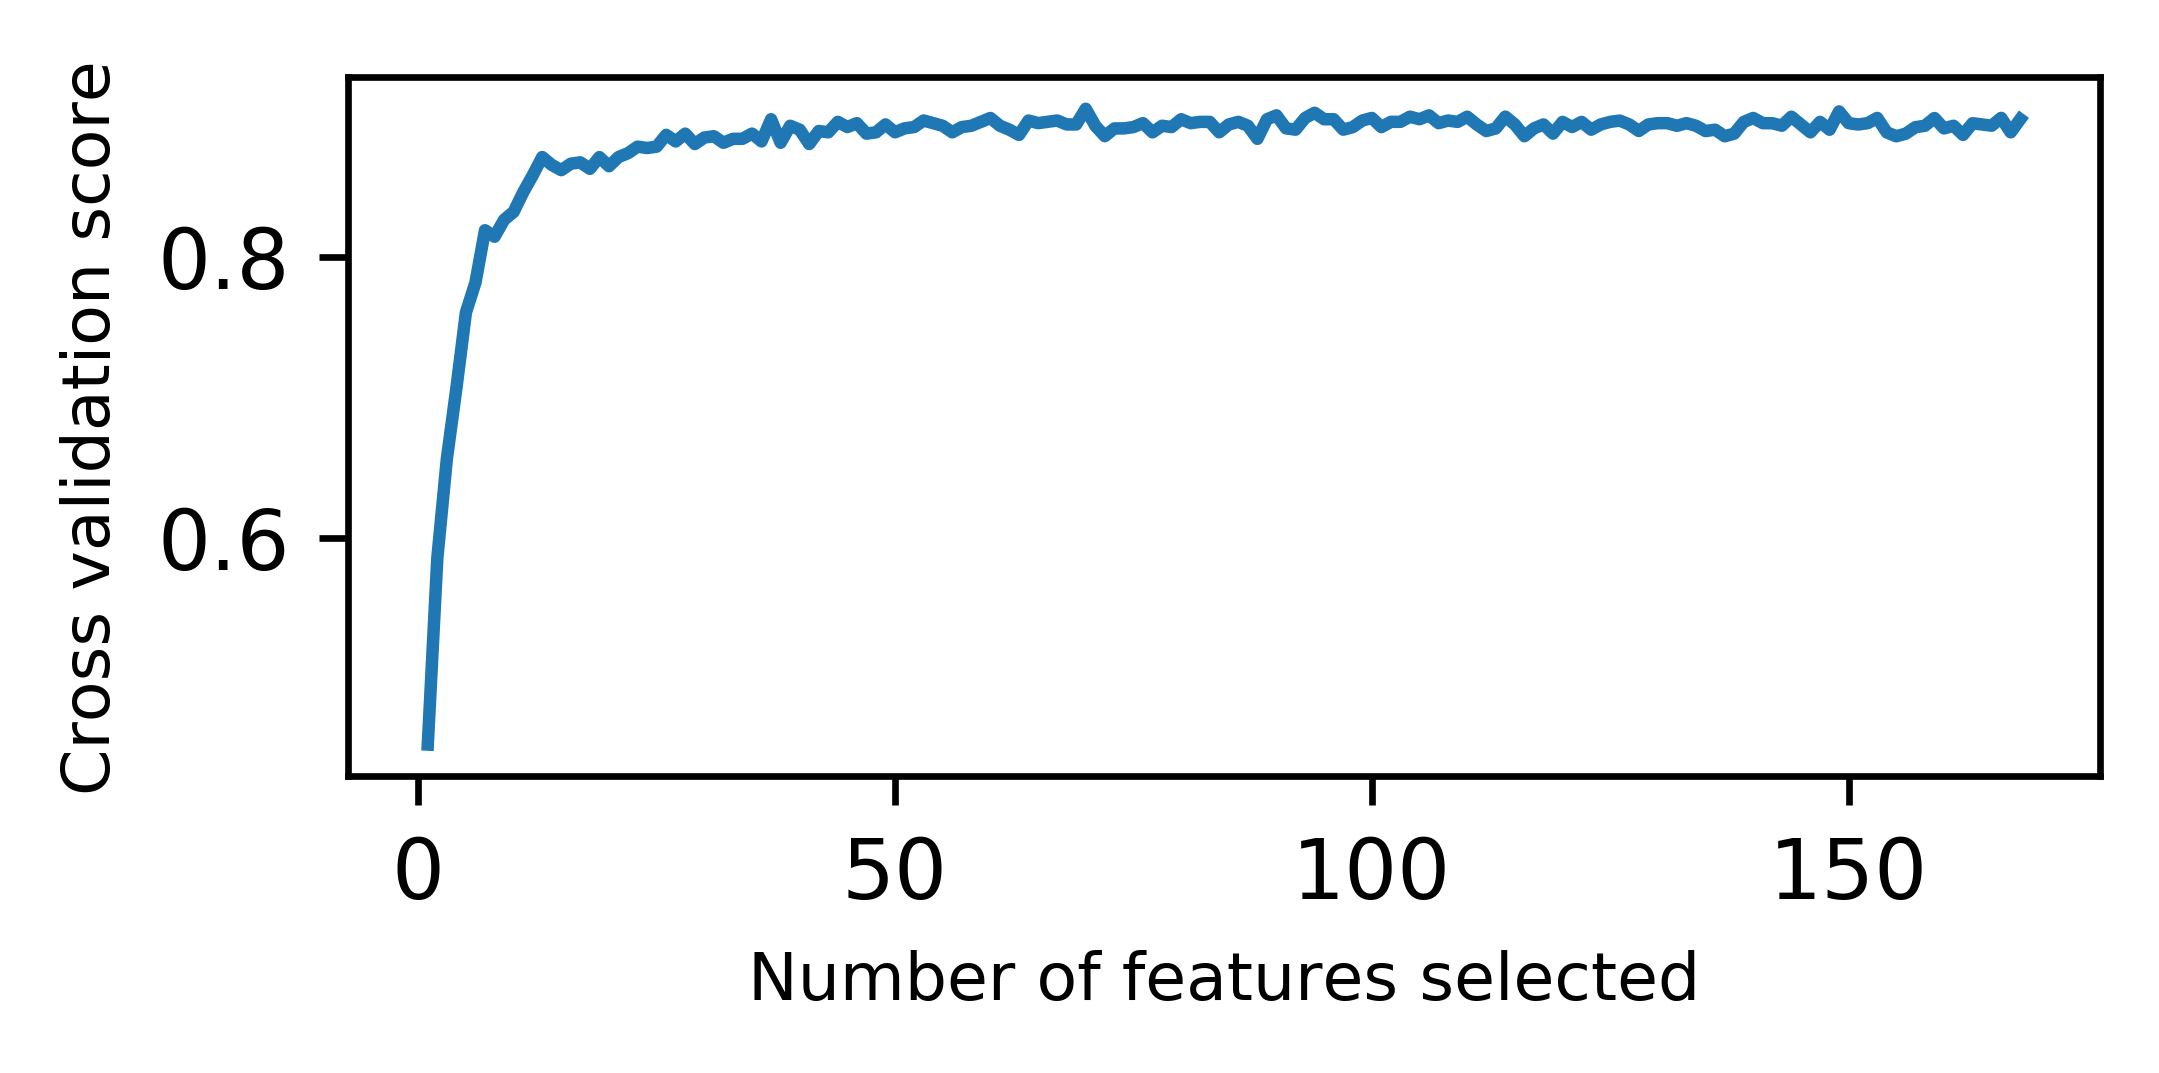

In [12]:
RFECV_plot = plt.figure(figsize = (3.7,1.86), dpi = 600)
plt.xlabel("Number of features selected", fontsize = 8)
plt.ylabel("Cross validation score", fontsize = 8)
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
# plt.show()
plt.tight_layout()

In [19]:
RFECV_plot.savefig('RFECV_os.png', bbox_inches='tight')

In [39]:
important_features = np.where(selector.ranking_ == 1)[0]
x_train_important = x_train[:,important_features]
x_test_important = x_test[:,important_features]

(65,)

In [41]:
def predict_func(learner, X_train, Y_train): 
    '''
    This function computes the training set accuracy and f1 score for different classifiers.
    USAGE: Accuracy and f1 score
    learner: the learning algorithm to be trained and predicted on
    X_train: features of the training set 
    Y_train: label of the training set
    OUTPUT: Numeric values representing the accuracy and f1 score 
    '''

    results = {}
    predictions_train = learner.predict(X_train)        
    results['accuracy'] = accuracy_score(Y_train, predictions_train)
    results['f1'] = f1_score(Y_train, predictions_train, average = 'weighted')
        
    return results 

In [42]:
# Logistic Regression parameters
lr_param= {'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag'],
           'max_iter': [100, 500,1000], 
           'multi_class': ['ovr'],  
           'penalty':['l1', 'l2']}  

# Random forrest parameters
rfc_param = {"max_depth": range(2, 10),
              "max_features": range(5, x_train_important.shape[1]),
              "min_samples_split": range(2, 5),
              "bootstrap": [True]}

# Ada Boost parameters
#Ada_param = {'algorithm': ['SAMME', 'SAMME.R'],'learning_rate' :[0.001, 0.0001, 0.00001,0.00001], 
#                  'n_estimators':range(0, x_train_important.shape[1])}



In [43]:
from sklearn import tree
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
#from sklearn.neural_network import MLPClassifier
from sklearn import svm
#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [44]:
lr = LogisticRegression()
rfc = RandomForestClassifier()
#Ada = AdaBoostClassifier()

results_feature_selecteion = {}
results_cv_feature_selecteion = {}
models_feature_selecteion = {}

for model, param in zip([lr, rfc],# Ada], 
                      [lr_param, rfc_param]):#, Ada_param]):
    
    clf_name = model.__class__.__name__

    scoring = make_scorer(accuracy_score)
    m_cv = GridSearchCV(model,
                  param_grid=param,
                  scoring=scoring, cv=5, refit=True, n_jobs=-1)

    m_cv.fit(x_train_important, y_train)
    m_cv.best_params_
                      
    models_feature_selecteion[clf_name] = m_cv
    
    results_cv_feature_selecteion[clf_name] = m_cv.cv_results_
    predictions = m_cv.best_estimator_.predict(x_train_important)
    results_feature_selecteion[clf_name] = predict_func(m_cv.best_estimator_, x_train_important, y_train)

In [45]:
results_feature_selecteion

{'LogisticRegression': {'accuracy': 0.7908921933085502,
  'f1': 0.7887400906141013},
 'RandomForestClassifier': {'accuracy': 0.9953531598513011,
  'f1': 0.9953589436045072}}

In [81]:
for key in models_feature_selecteion.keys():
    print(models_feature_selecteion[key].best_estimator_)

LogisticRegression(multi_class='ovr', solver='newton-cg')
RandomForestClassifier(max_depth=9, max_features=10, min_samples_split=4)


In [55]:
rfc = RandomForestClassifier(max_depth=9, max_features=10, min_samples_split=4, random_state=42)
rfc.fit(x_train_important, y_train)



RandomForestClassifier(max_depth=9, max_features=10, min_samples_split=4,
                       random_state=42)

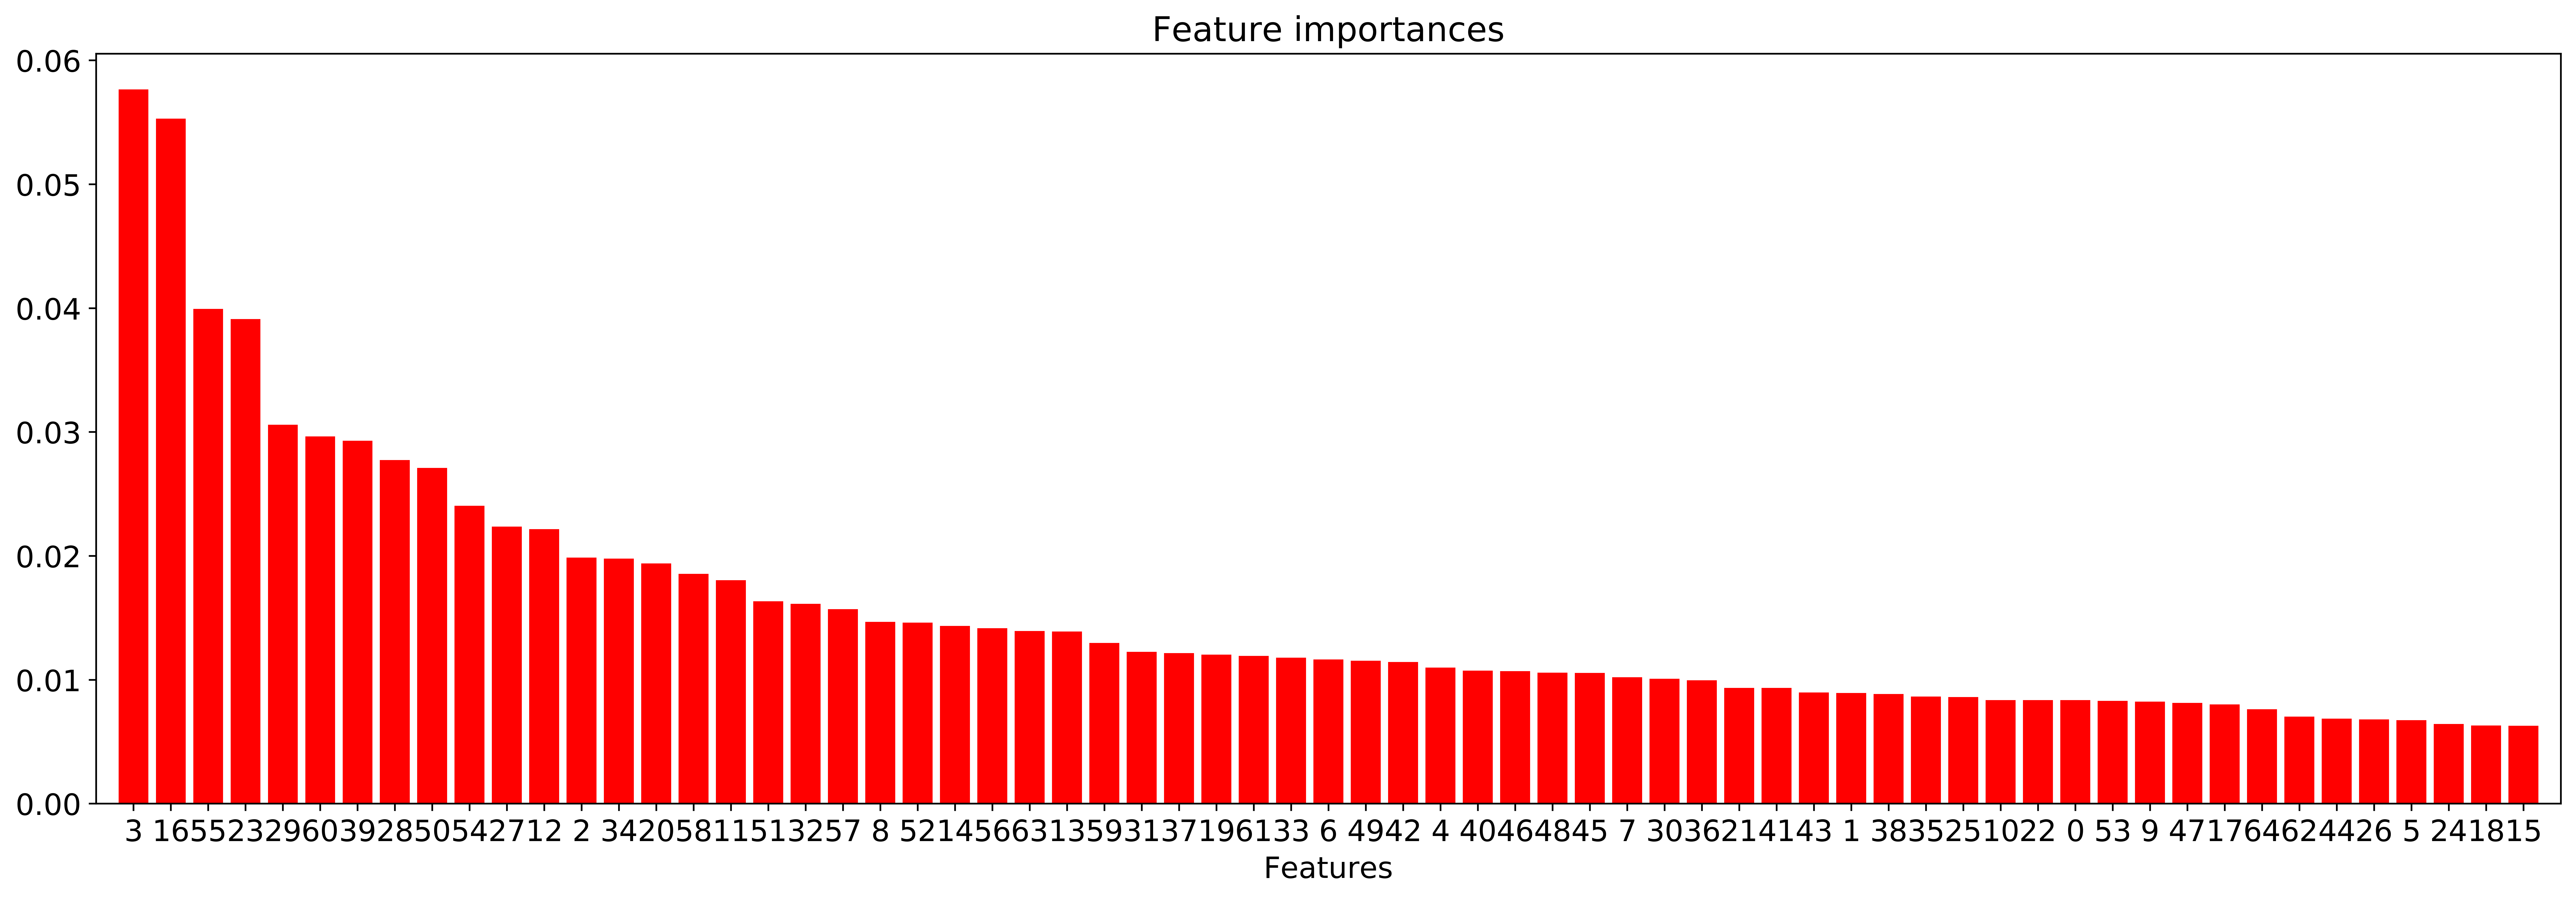

In [51]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

fig_featimp, ax1 = plt.subplots(figsize = (17,6), dpi = 600) 
#plt.figure(figsize=(20,5))
#plt.title("Feature importances")
ax1.bar(range(x_train_important.shape[1]), importances[indices],
        color="r")#, yerr=std[indices], align="center")


#ax1 = sns.barplot(x = x_train_important.shape[1], y = importances[indices], color ='green')

plt.xticks(range(x_train_important.shape[1]), indices)
plt.xlim([-1, x_train_important.shape[1]])
#ticks = ['AccZ temporal stat', AccZ succesive differences', 'AccX linear autocorrelation', 'AccZ statistical measure of complexity', 
#         'Emotional stress', 'Physical stress', 'Relax']
#plt.xticks(ticks=[3,16,55,23,29,60,39,28,50,54,27,12,2,34,20,58,11,51,32,57,8,52,14,56,63,13,59,
#                  31,37,19,61,33,6,49,42,4,40,46,48,45,7,30,36,21,41,43,1,38,35,25,10,22,0,53,9,
#                  47,17,64,62,42,44,26,5,24,18,15, labels = ticks, rotation = 90 )


ax1.set_title("Feature importances", fontsize = 16)
ax1.set_xlabel("Features", fontsize=14)
ax1.set_ylabel('', fontsize=8)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=7)
#ax1.legend(loc='top left', fontsize=8)

plt.tight_layout()

In [52]:
fig_featimp.savefig('feat_imp.png', bbox_inches='tight')

In [56]:
rfc_prediction = rfc.predict(x_test_important)

In [19]:
print('Confusion Matrix:\n', confusion_matrix(y_test, rfc_prediction))
print('f1 score =', f1_score(y_test, rfc_prediction, average = 'weighted'))
print('Accuracy =', accuracy_score(y_test, rfc_prediction))

Confusion Matrix:
 [[ 95   5   1   6]
 [  2  98   1  22]
 [  2   1 113   4]
 [  6   1   0 105]]
f1 score = 0.8906821540363803
Accuracy = 0.8896103896103896


In [57]:
print(classification_report(y_test, rfc_prediction, target_names = ['Emotional Stress', 'Physical Stress', 'Relax', 'Cognitive Stress']))

                  precision    recall  f1-score   support

Emotional Stress       0.92      0.82      0.86       119
 Physical Stress       0.94      0.73      0.82       123
           Relax       0.88      0.95      0.91       112
Cognitive Stress       0.71      0.92      0.80       108

        accuracy                           0.85       462
       macro avg       0.86      0.85      0.85       462
    weighted avg       0.86      0.85      0.85       462



Text(0.5, 1, 'F1 Score: 0.85')

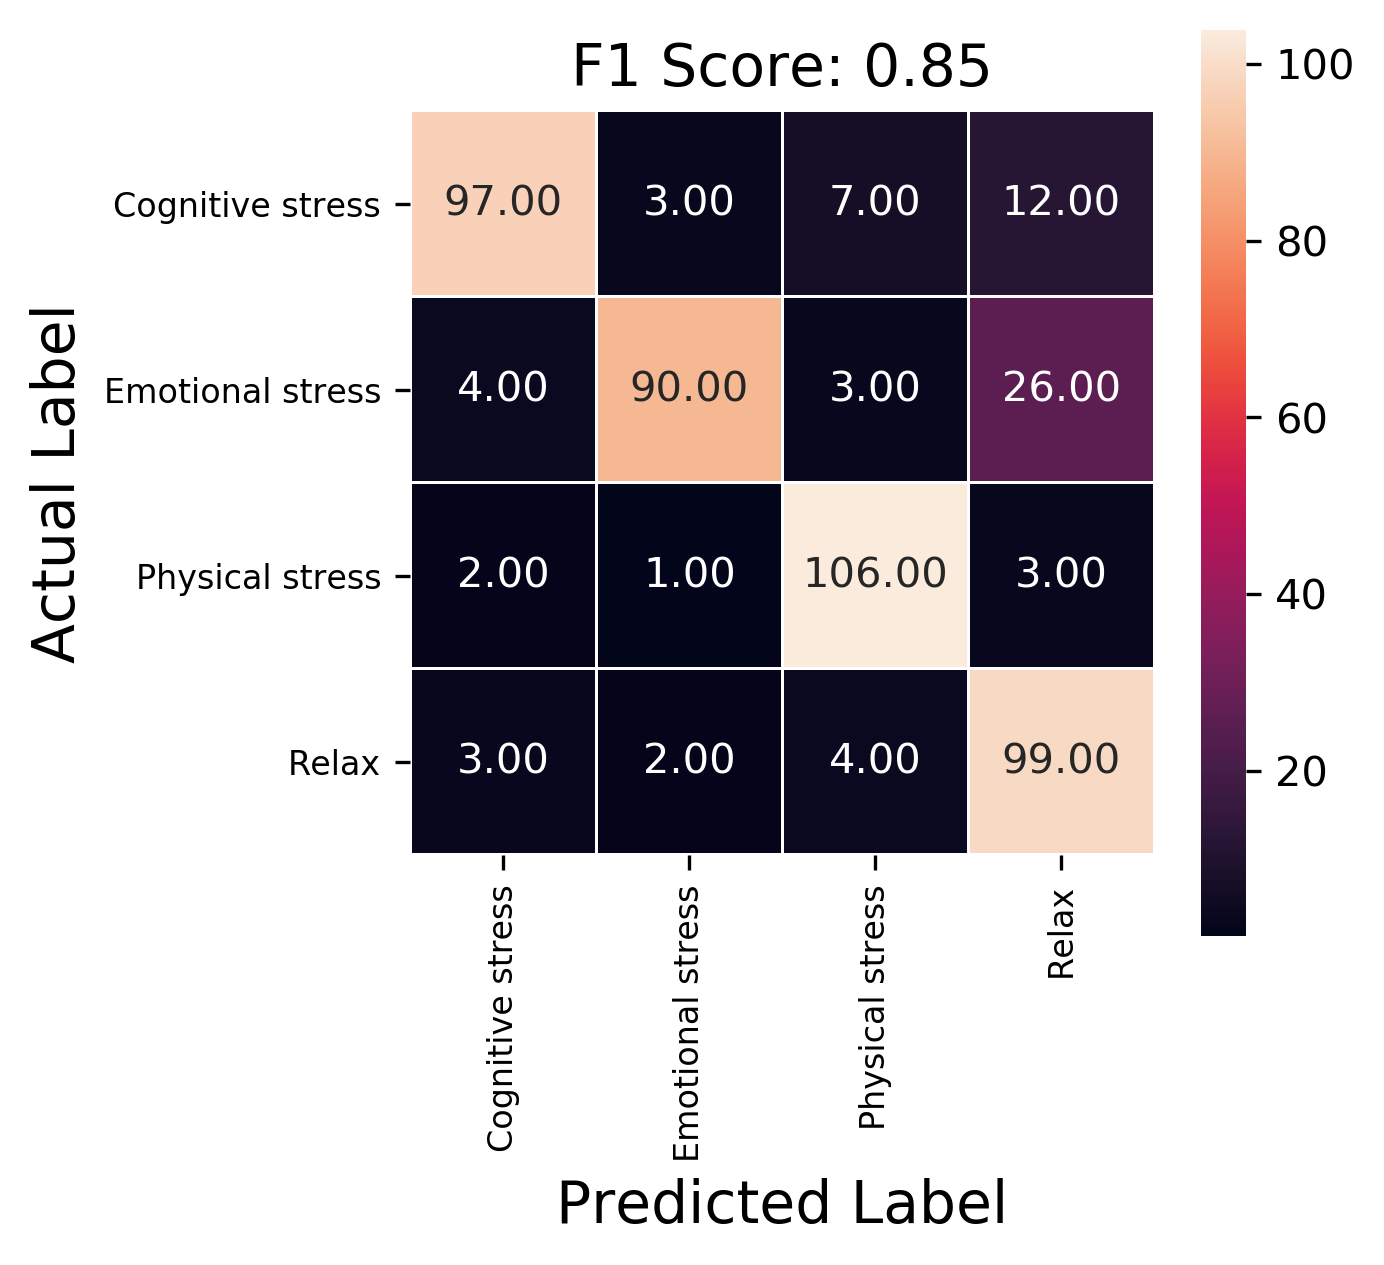

In [59]:

cm = metrics.confusion_matrix(y_test, rfc_prediction)
#cm
con_m = plt.figure(figsize=(4,4), dpi =300)
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, robust=True, fmt='.2f', linewidths=0.5, square =True)#, cmap = 'Blues_r', )
plt.ylabel('Actual Label', fontsize = 14)
plt.xlabel('Predicted Label', fontsize = 14)
ticks = ['Cognitive stress', 'Emotional stress', 'Physical stress', 'Relax']
plt.xticks(ticks=[0.5,1.5,2.5,3.5], labels = ticks, rotation = 90 )
plt.yticks(ticks=[0.5,1.5,2.5,3.5], labels = ticks, rotation = 0)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=7)
plt.title('F1 Score: {0:0.2f}'.format(f1_score(y_test, rfc_prediction, average = 'weighted')), size = 14)

In [60]:
con_m.savefig('rfc_cm_heatmap.png', bbox_inches='tight')

In [61]:
lb = preprocessing.LabelBinarizer()
lb.fit(y_test)
yb_test = lb.transform(y_test)

In [64]:
lb.fit(rfc_prediction)
class_prediction_b = lb.transform(rfc_prediction)

/home/amir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


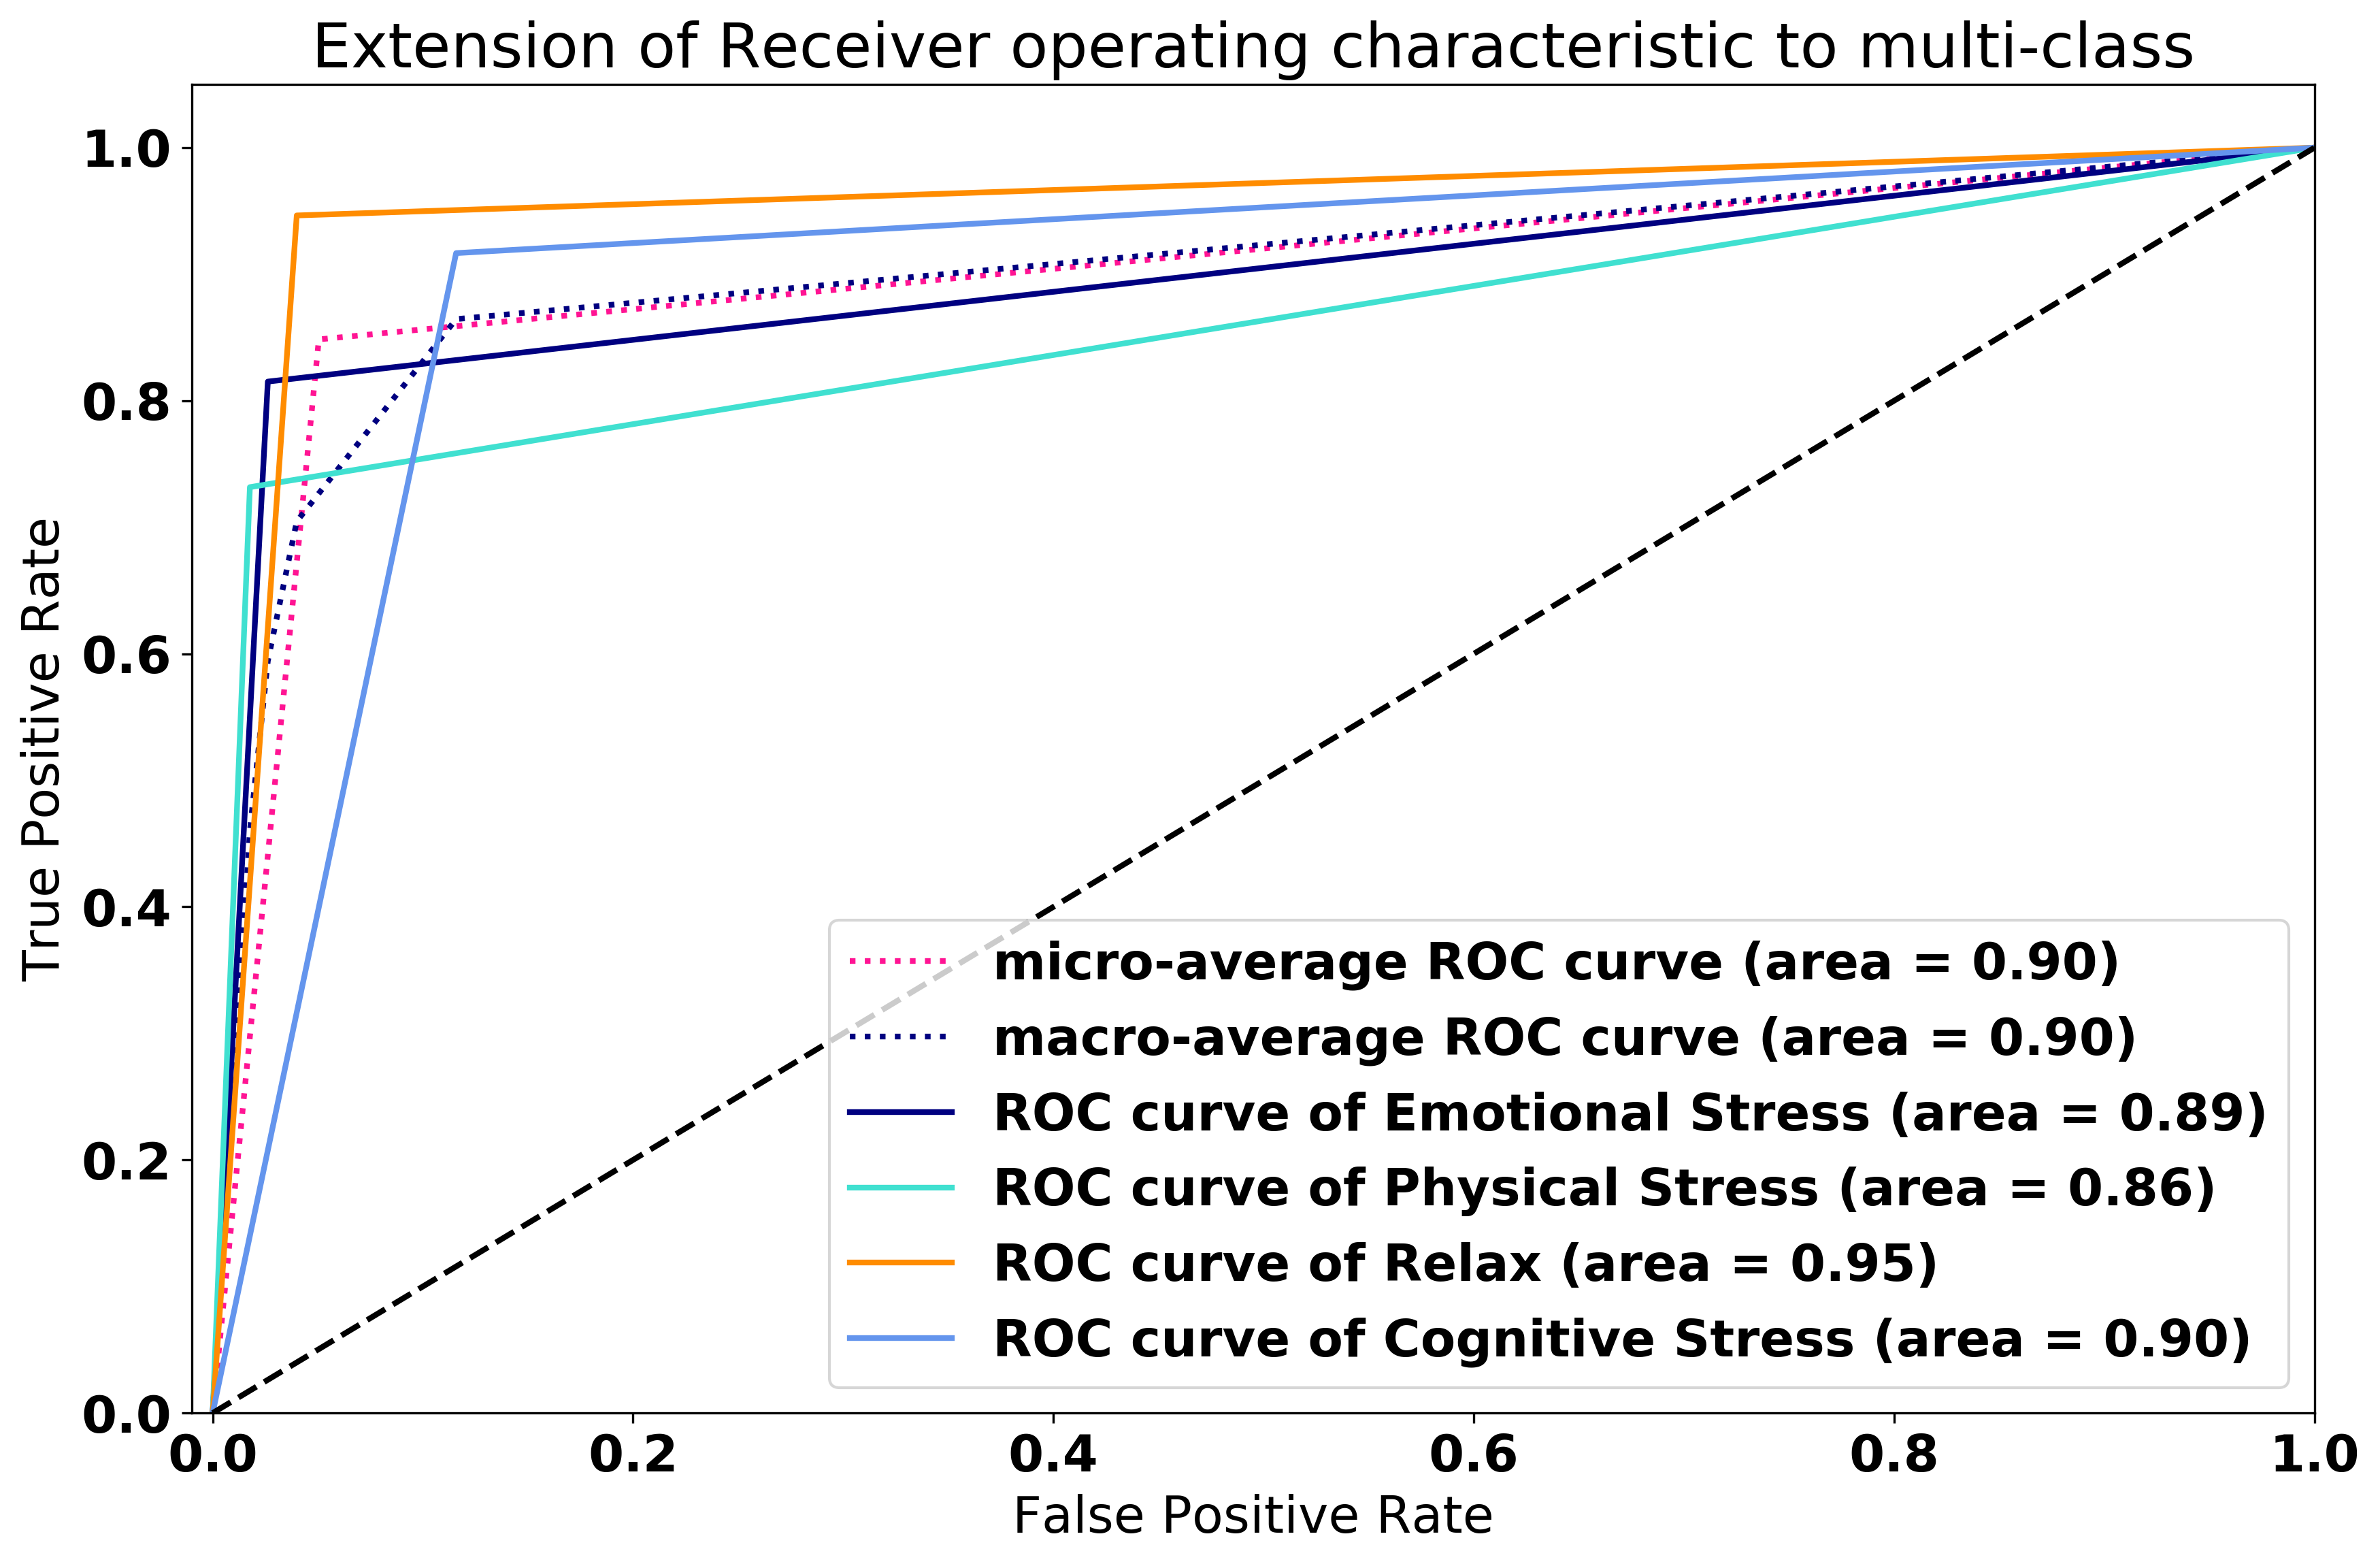

In [75]:
# ROC curve

colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'red', 'teal'])#, 'blue', 'k'])


fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yb_test[:, i], class_prediction_b[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yb_test.ravel(), class_prediction_b.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
#fig_roc, c_ax = plt.subplots(1,1, figsize = (12, 8))

ROC_plot = plt.figure(figsize=(12, 8), dpi = 300)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)
class_names = ['Emotional Stress', 'Physical Stress', 'Relax', 'Cognitive Stress']
for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

    
    
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('Extension of Receiver operating characteristic to multi-class', fontsize = 22)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.legend(loc="lower right", fontsize = 18)
plt.tight_layout()
plt.show()

In [76]:
ROC_plot.savefig('RFC_ROC.png', bbox_inches='tight')